In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Move to working folder
%cd /content/drive/MyDrive/Projects/AIA

/content/drive/MyDrive/Projects/AIA


In [1]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utils.lbp import LBP
from utils.dataset import load_yolo_labels
from utils.iou import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


In [2]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = '/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'txt'

## Histogram Matching

In [3]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)

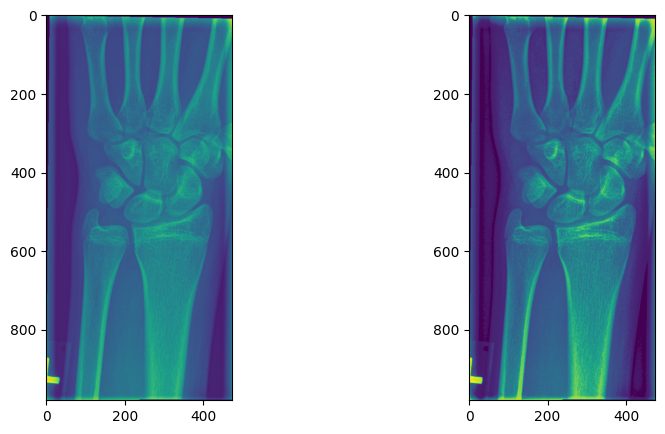

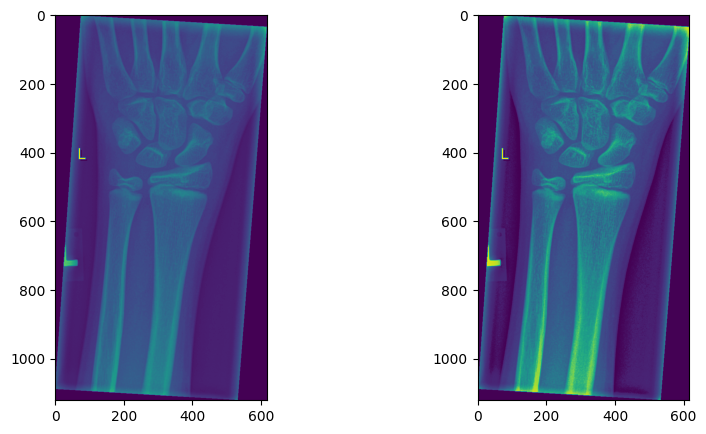

In [4]:
## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if i > 1:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [4]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


In [5]:
def process_image_and_labels(image_path, root_path, label_folder, mean_histogram, intensity_crop, outputbitdepth):
    """
    Processes an image by preprocessing and loading corresponding labels.

    Args:
    image_path (str): Path to the image file.
    root_path (str): Base path for data.
    label_folder (str): Folder containing label files.
    mean_histogram (bool): Flag for histogram processing.
    intensity_crop (tuple): Intensity cropping parameters.
    outputbitdepth (int): Bit depth for image output.

    Returns:
    tuple: A tuple containing the processed image and associated labels.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    ### Parse label
    image_name = os.path.basename(image_path)
    label_path = os.path.join(root_path, label_folder, image_name.replace('.png', '.txt'))
    labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Segment bones
    img = preprocess(img, mean_histogram=mean_histogram, intensity_crop=intensity_crop, outputbitdepth=outputbitdepth)
    
    return img, labels

## Extract Features

In [6]:
windowSize = 256
stepSize = 128 
# Parameters for LBP
num_points = 16  # Typically 8, 16, or 24
radius = 7       # Typical values are 1, 2, or 3
background_removal_threshold = 30 # Threshold for removing background in percentage

In [7]:
convert_grayscale = False
outputbitdepth = 8 # Set output bit depth
sharpen = False # Sharpen image
convert_grayscale = False # Convert to grayscale
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

In [8]:
num_features = 100

In [11]:
### Extract LBP features and export to npy file
mode = 'train'
class_name = 'normal'
export_path_fracture = os.path.join(root_path, f'{mode}_{class_name}_lbp.npy')
export_path_non_fracture = os.path.join(root_path, f'{mode}_non_{class_name}_lbp.npy')
export_path_normal = os.path.join(root_path, f'{mode}_normal_lbp.npy')

fracture_features = []
non_fracture_features = []

### Local Binary Pattern
lbp = LBP(num_points, radius)
### Histogram of Oriented Gradients
hog = cv2.HOGDescriptor()

### Loop through all images
for image_path in glob.glob(os.path.join(root_path, mode, class_name, '*.png')):
    print(f"Processing {image_path}")
    
    ### Extract LBP features
    image, labels = process_image_and_labels(image_path, root_path, label_folder, mean_histogram, intensity_crop, outputbitdepth)
    
    for i, (x, y, window_img) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        # ## Image histogram 
        # hist, bins = np.histogram(window_img.flatten(), bins=256, range=[0, 256])
        lbp_features = lbp.get_lbp_image(window_img)
        hog_features = hog.compute(window_img)
        lbp_features = lbp_features.ravel()
        hog_features = hog_features.ravel()
        
        combined_features = np.concatenate([lbp_features, hog_features])
        combined_features = combined_features.astype(np.float32)
        
        is_fracture = False
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.7:
                fracture_features.append(combined_features)
                is_fracture = True
                break
        # If no label has matched after checking all, it's a non-fracture case
        if not is_fracture:
            non_fracture_features.append(combined_features)

Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0045_0661159881_01_WRI-L1_M010.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0052_1061971533_01_WRI-R2_F011.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0073_1210326335_02_WRI-R1_M017.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0087_0493070693_01_WRI-R2_F003.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0012_0542128240_01_WRI-L2_M013.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0057_0927207258_01_WRI-R2_M010.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/test/normal/0066_1261436285_02_WRI-L2_M011.png
Processing /Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset

In [12]:
### Export to npy file normal
np.save(export_path_normal, np.array(non_fracture_features[:1000]))

OSError: 5036172432 requested and 4294965248 written

In [10]:
### Export to npy file fracture and non-fracture
np.save(export_path_fracture, fracture_features)
np.save(export_path_non_fracture, non_fracture_features[:1000])

In [16]:
import gc

del fracture_features
del non_fracture_features

gc.collect()

NameError: name 'fracture_features' is not defined

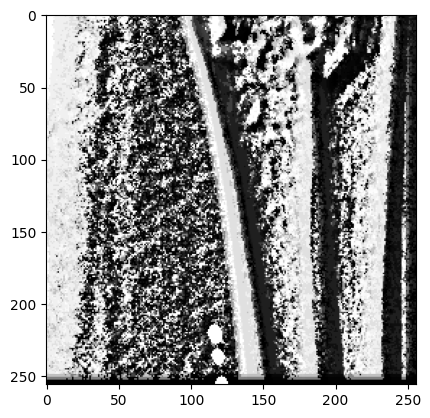

In [45]:
features = np.load(export_path_fracture)
plt.imshow(features[1].reshape(256, 256), cmap='gray')
plt.show()

## Machine Learning Model

### Load data

In [48]:
dataset_path = '/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/MLDataset/'

In [49]:
train_normal_features = np.load(os.path.join(dataset_path, 'train_normal_lbp.npy'))[:100]
train_fracture_features = np.load(os.path.join(dataset_path, 'train_fracture_lbp.npy'))[:100]
train_features = np.concatenate([train_normal_features, train_fracture_features])
train_labels = np.array([0] * len(train_normal_features) + [1] * len(train_fracture_features))

test_normal_features = np.load(os.path.join(dataset_path, 'test_normal_lbp.npy'))
test_fracture_features = np.load(os.path.join(dataset_path, 'test_fracture_lbp.npy'))
test_features = np.concatenate([test_normal_features, test_fracture_features])
test_labels = np.array([0] * len(test_normal_features) + [1] * len(test_fracture_features))

In [16]:
## Histogram of LBP features
train_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in train_features]
test_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in test_features]

In [50]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

### Training

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
# model = SVC(kernel='linear')
model = RandomForestClassifier(n_estimators=200, random_state=42)
# model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [53]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.43      0.44        21
           1       0.40      0.42      0.41        19

    accuracy                           0.42        40
   macro avg       0.43      0.42      0.42        40
weighted avg       0.43      0.42      0.43        40



In [54]:
# Evaluate the model on the valid set
y_pred_test = model.predict(test_features)
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.48      0.63      3012
           1       0.17      0.73      0.27       426

    accuracy                           0.51      3438
   macro avg       0.55      0.61      0.45      3438
weighted avg       0.83      0.51      0.59      3438



In [14]:
# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_test)
print(cm)

[[1412 1600]
 [ 122  304]]


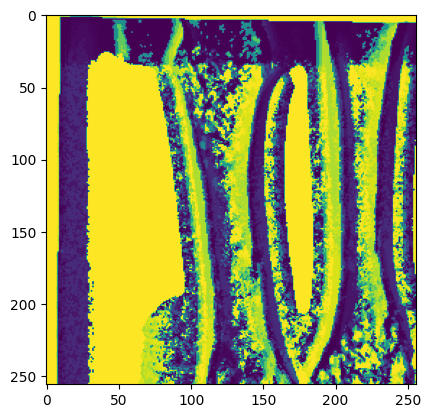

In [26]:
for x in train_features:
    plt.imshow(x.reshape(256, 256))
    plt.show()
    break

(-0.5, 999.5, 999.5, -0.5)

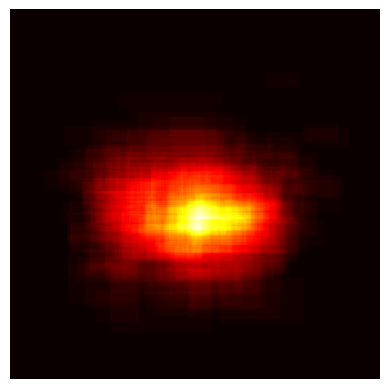

In [7]:
heatmap = np.load('./heatmap.npy')
coords = np.column_stack(np.where(heatmap > 0))
top_left = coords.min(axis=0)
bottom_right = coords.max(axis=0)
plt.imshow(heatmap, cmap='hot')
plt.axis('off')

In [ ]:
from utils.vis import draw_bboxes

image_files = glob.glob(os.path.join(root_path, 'test/**/*.png'), recursive=True)

## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if 'fracture' not in image_file:
        continue
    print(f"Processing {image_file}")
    ### Parse label
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image_name = os.path.basename(image_file)
    label_path = os.path.join(root_path, label_folder, image_name.replace('.png', '.txt'))
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    draw_bboxes(image, labels)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]

    _, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image, cmap='gray')
    fig[0].axis('off')
    fig[1].imshow(roi_image, cmap='gray')
    fig[1].axis('off')
    
    plt.show()